# Gastric-Brain Coupling with GastroPy

This tutorial walks you through a complete gastric-brain phase coupling
analysis. We use real fMRI-concurrent EGG data from GastroPy's bundled
samples and synthetic BOLD phases to demonstrate the full pipeline from
raw EGG to voxelwise coupling maps.

**What you will learn:**
- What gastric-brain coupling is and why phase-locking value (PLV) is used
- How to extract per-volume EGG phase from fMRI-concurrent recordings
- How to compute voxelwise PLV between EGG and BOLD phases
- How to test significance using circular time-shift surrogates
- How to interpret coupling maps and circular statistics
- How to use `regress_confounds` and `bold_voxelwise_phases` for real BOLD data

**Prerequisites:** Familiarity with the
[EGG Processing Tutorial](egg_processing.ipynb). Basic knowledge of
fMRI analysis (volumes, TR, confound regression) is helpful but not required.

**References:**

Banellis, L., Rebollo, I., Nikolova, N., & Allen, M. (2025). Stomach-brain
coupling indexes a dimensional signature of mental health. *Nature Mental Health*.

Rebollo, I., Devaez, I., Bravo, R., & Tallon-Baudry, C. (2018). Stomach-brain
synchrony reveals a novel, delayed-connectivity resting-state network in humans.
*eLife*, 7, e33321.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gastropy as gp
from gastropy.neuro.fmri import (
    apply_volume_cuts,
    compute_plv_map,
    compute_surrogate_plv_map,
    create_volume_windows,
    phase_per_volume,
)

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

## 1. Background: Gastric-Brain Phase Coupling

The stomach generates a continuous electrical oscillation at ~0.05 Hz
(3 cycles per minute). This **gastric rhythm** can be measured
non-invasively via electrogastrography (EGG) while simultaneously
recording brain activity with fMRI.

**Gastric-brain coupling** refers to the statistical relationship
between the phase of the gastric rhythm and the phase of slow
BOLD fluctuations at the same frequency. When a brain region's
BOLD signal oscillates in a consistent phase relationship with the
stomach, we say they are **phase-locked**.

### Phase-Locking Value (PLV)

PLV measures the consistency of the phase difference between two
signals across time:

$$\text{PLV} = \left| \frac{1}{N} \sum_{t=1}^{N} e^{i(\phi_\text{BOLD}(t) - \phi_\text{EGG}(t))} \right|$$

- **PLV = 1**: Perfect phase-locking (constant phase difference)
- **PLV = 0**: No coupling (random phase difference)

### The Analysis Pipeline

The standard pipeline (Rebollo et al., 2018; Banellis et al., 2025) is:

1. **EGG side**: Identify the individual gastric peak frequency, bandpass
   filter the EGG, extract instantaneous phase, map to per-volume phases
2. **BOLD side**: Regress out confounds (motion, physiological noise),
   bandpass filter each voxel at the same gastric frequency, extract phase
3. **Coupling**: Compute PLV between EGG phase and each voxel's phase
4. **Statistics**: Test significance via circular time-shift surrogates

## 2. Loading fMRI-Concurrent EGG Data

GastroPy ships with 8-channel EGG recordings collected concurrently
with fMRI. The data includes scanner trigger times for mapping between
EGG timepoints and fMRI volumes.

In [2]:
fmri = gp.load_fmri_egg(session="0001")

print(f"Signal shape:  {fmri['signal'].shape}  (8 channels x {fmri['signal'].shape[1]} samples)")
print(f"Sampling rate: {fmri['sfreq']} Hz")
print(f"TR:            {fmri['tr']} s")
print(f"Volumes:       {len(fmri['trigger_times'])}")
print(f"Duration:      {fmri['duration_s']:.0f} s ({fmri['duration_s'] / 60:.1f} min)")

Signal shape:  (8, 7795)  (8 channels x 7795 samples)
Sampling rate: 10.0 Hz
TR:            1.856 s
Volumes:       420
Duration:      780 s (13.0 min)


## 3. EGG Processing: Channel Selection and Peak Frequency

The first step is to identify the best EGG channel and its individual
gastric peak frequency. This frequency will be used to filter both
the EGG and BOLD signals.

In [3]:
sfreq = fmri["sfreq"]
tr = fmri["tr"]
ch_names = list(fmri["ch_names"])

best_idx, peak_freq, freqs, psd = gp.select_best_channel(fmri["signal"], sfreq)
print(f"Best channel: {ch_names[best_idx]} (index {best_idx})")
print(f"Peak frequency: {peak_freq:.4f} Hz ({peak_freq * 60:.2f} cpm)")
print(f"Peak period: {1 / peak_freq:.1f} s")

# Compute all-channel PSD for the overview plot
all_psd = np.column_stack([gp.psd_welch(fmri["signal"][i], sfreq)[1] for i in range(fmri["signal"].shape[0])]).T

Best channel: EGG8 (index 7)
Peak frequency: 0.0400 Hz (2.40 cpm)
Peak period: 25.0 s


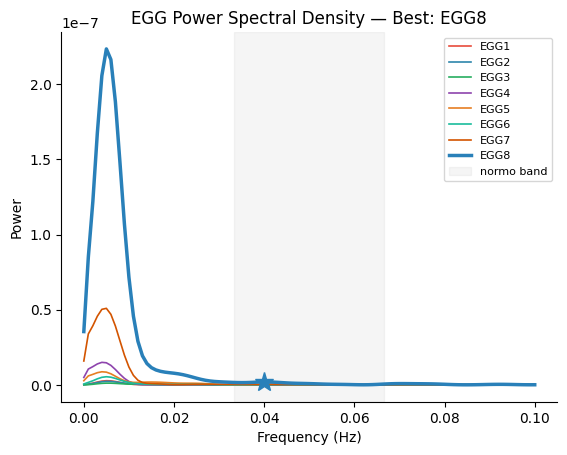

In [4]:
fig, ax = gp.plot_psd(freqs, all_psd, best_idx=best_idx, peak_freq=peak_freq, ch_names=ch_names)
ax.set_title(f"EGG Power Spectral Density — Best: {ch_names[best_idx]}")
plt.show()

## 4. Narrowband Filtering at Individual Peak Frequency

Both EGG and BOLD must be filtered at the **same** frequency —
the individual gastric peak. We use a narrow band of
`peak_freq ± 0.015 Hz` (half-width at half-maximum), matching
the validated parameters from Banellis et al. (2025).

This is narrower than the normogastric band (0.033–0.067 Hz)
because coupling analysis requires matching the exact same
frequency in both signals.

In [5]:
hwhm = 0.015  # Hz
low_hz = peak_freq - hwhm
high_hz = peak_freq + hwhm
print(f"Filter band: {low_hz:.4f} - {high_hz:.4f} Hz")
print(f"Filter band: {low_hz * 60:.2f} - {high_hz * 60:.2f} cpm")

filtered, filt_info = gp.apply_bandpass(
    fmri["signal"][best_idx],
    sfreq,
    low_hz=low_hz,
    high_hz=high_hz,
)
phase, analytic = gp.instantaneous_phase(filtered)

Filter band: 0.0250 - 0.0550 Hz
Filter band: 1.50 - 3.30 cpm


## 5. Per-Volume Phase Extraction

The EGG is sampled at 10 Hz, but fMRI volumes are acquired every
TR = 1.856 s. We need to map the continuous EGG phase to one
phase value per fMRI volume, by averaging the complex analytic
signal within each volume's acquisition window.

We then trim transient volumes from each edge to avoid filter
ringing artifacts.

In [6]:
n_volumes = len(fmri["trigger_times"])
windows = create_volume_windows(fmri["trigger_times"], tr, n_volumes)
egg_vol_phase = phase_per_volume(analytic, windows)

# Trim transient volumes (21 from each edge)
begin_cut, end_cut = 21, 21
egg_phase = apply_volume_cuts(egg_vol_phase, begin_cut, end_cut)
n_trimmed = len(egg_phase)

print(f"Volume phases: {n_volumes} -> trimmed: {n_trimmed}")
print(f"Phase range: [{egg_phase.min():.2f}, {egg_phase.max():.2f}] rad")

Volume phases: 420 -> trimmed: 378
Phase range: [-2.79, -1.24] rad


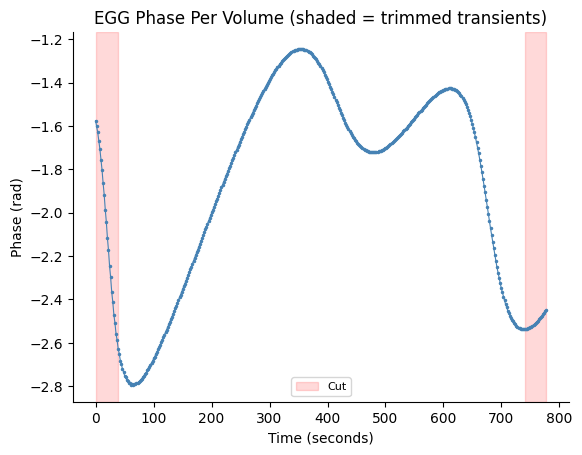

In [7]:
fig, ax = gp.plot_volume_phase(egg_vol_phase, tr=tr, cut_start=begin_cut, cut_end=end_cut)
ax.set_title("EGG Phase Per Volume (shaded = trimmed transients)")
plt.show()

### Circular Statistics of EGG Phase

We can check the EGG phase distribution using circular statistics.
The per-volume phases should span the full circle (low resultant
length) since the gastric rhythm cycles continuously.

In [8]:
z_egg, p_egg = gp.rayleigh_test(egg_phase)
print("EGG volume phases:")
print(f"  Circular mean:     {gp.circular_mean(egg_phase):.4f} rad")
print(f"  Resultant length:  {gp.resultant_length(egg_phase):.4f}")
print(f"  Rayleigh test:     z = {z_egg:.2f}, p = {p_egg:.4f}")

EGG volume phases:
  Circular mean:     -1.8270 rad
  Resultant length:  0.8922
  Rayleigh test:     z = 300.91, p = 0.0000


## 6. BOLD-Side Processing (Overview)

In a real analysis with NIfTI files from fMRIPrep, the BOLD processing
would use:

```python
from gastropy.neuro.fmri import regress_confounds, bold_voxelwise_phases
import nibabel as nib
import pandas as pd

# Load NIfTI and mask
bold_img = nib.load("bold_preproc.nii.gz")
mask_img = nib.load("brain_mask.nii.gz")
bold_data = bold_img.get_fdata()          # (x, y, z, time)
mask = mask_img.get_fdata().astype(bool)   # (x, y, z)

# Extract voxels within mask -> (n_voxels, n_timepoints)
bold_2d = bold_data[mask].T  # or bold_data[mask]

# Confound regression (motion + aCompCor)
confounds = pd.read_csv("confounds.tsv", sep="\t")
residuals = regress_confounds(bold_2d, confounds)

# Extract phase at gastric frequency
sfreq_bold = 1 / tr
bold_phases = bold_voxelwise_phases(
    residuals, peak_freq_hz=peak_freq, sfreq=sfreq_bold,
    begin_cut=21, end_cut=21,
)
```

For this tutorial, we simulate BOLD phases with known coupling
properties to demonstrate the analysis steps.

In [9]:
rng = np.random.default_rng(42)
n_voxels = 100

# 20 coupled voxels: EGG phase + offset + noise
coupled = np.zeros((20, n_trimmed))
for i in range(20):
    offset = rng.uniform(0, 2 * np.pi)
    noise = 0.3 + 0.5 * (i / 20)  # increasing noise levels
    coupled[i] = egg_phase + offset + noise * rng.standard_normal(n_trimmed)

# 80 random (uncoupled) voxels
random_phases = rng.uniform(-np.pi, np.pi, (80, n_trimmed))
bold_phases = np.vstack([coupled, random_phases])

print(f"Simulated BOLD phases: {bold_phases.shape}")
print("  Voxels 0-19:  coupled to EGG")
print("  Voxels 20-99: random (no coupling)")

Simulated BOLD phases: (100, 378)
  Voxels 0-19:  coupled to EGG
  Voxels 20-99: random (no coupling)


## 7. Computing the PLV Map

Now we compute PLV between the EGG phase and each BOLD voxel's
phase. `compute_plv_map` is a convenience function that calls
`phase_locking_value` with the appropriate array layout.

In [10]:
plv_map = compute_plv_map(egg_phase, bold_phases)

print(f"PLV map: {len(plv_map)} voxels")
print(f"  Coupled (mean +/- std): {plv_map[:20].mean():.4f} +/- {plv_map[:20].std():.4f}")
print(f"  Random  (mean +/- std): {plv_map[20:].mean():.4f} +/- {plv_map[20:].std():.4f}")

PLV map: 100 voxels
  Coupled (mean +/- std): 0.8591 +/- 0.0667
  Random  (mean +/- std): 0.0431 +/- 0.0206


### Understanding PLV: The Phase Difference

PLV is mathematically equivalent to the resultant length of the
phase difference distribution. Let's visualize this for one coupled
and one random voxel.

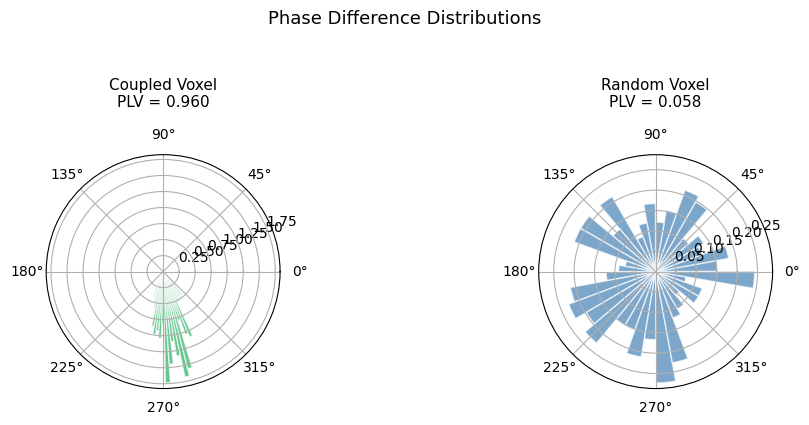

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={"projection": "polar"})

# Coupled voxel
diff_coupled = np.angle(np.exp(1j * (bold_phases[0] - egg_phase)))
ax1.hist(diff_coupled, bins=36, density=True, alpha=0.7, color="#27AE60", edgecolor="white")
R_c = gp.resultant_length(diff_coupled)
mean_c = gp.circular_mean(diff_coupled)
ax1.set_title(f"Coupled Voxel\nPLV = {R_c:.3f}", fontsize=11, pad=15)

# Random voxel
diff_random = np.angle(np.exp(1j * (bold_phases[50] - egg_phase)))
ax2.hist(diff_random, bins=36, density=True, alpha=0.7, color="steelblue", edgecolor="white")
R_r = gp.resultant_length(diff_random)
ax2.set_title(f"Random Voxel\nPLV = {R_r:.3f}", fontsize=11, pad=15)

fig.suptitle("Phase Difference Distributions", fontsize=13, y=1.05)
fig.tight_layout()
plt.show()

The coupled voxel shows a concentrated phase difference distribution
(high PLV), while the random voxel's distribution is nearly uniform
(low PLV).

## 8. Complex PLV: Preferred Phase Lag

The complex PLV preserves both the coupling strength (magnitude)
and the preferred phase lag (angle). The phase lag tells us *when*
in the gastric cycle a brain region is most active.

In [12]:
cplv = gp.phase_locking_value_complex(bold_phases[:20].T, egg_phase)

print("Coupled voxels — preferred phase lags:")
for i in [0, 5, 10, 15, 19]:
    mag = np.abs(cplv[i])
    lag = np.rad2deg(np.angle(cplv[i])) % 360
    print(f"  Voxel {i:2d}: PLV = {mag:.3f}, lag = {lag:.1f} deg")

Coupled voxels — preferred phase lags:
  Voxel  0: PLV = 0.960, lag = 278.7 deg
  Voxel  5: PLV = 0.921, lag = 78.6 deg
  Voxel 10: PLV = 0.867, lag = 148.2 deg
  Voxel 15: PLV = 0.776, lag = 263.8 deg
  Voxel 19: PLV = 0.756, lag = 123.0 deg


## 9. Surrogate Statistical Testing

Observed PLV may be non-zero by chance due to autocorrelation in
both signals. To test whether coupling is statistically significant,
we use the **median rotation method** (Banellis et al., 2025):

1. Circularly shift the EGG phase time series by a random amount
2. Recompute PLV with the shifted EGG
3. Repeat for many shifts to build a null distribution
4. Compare empirical PLV to the null

Circular shifting preserves the autocorrelation structure of both
signals while destroying the true temporal alignment.

In [13]:
# Median surrogate PLV across 200 circular shifts
surr_map = compute_surrogate_plv_map(
    egg_phase,
    bold_phases,
    n_surrogates=200,
    seed=42,
)

print("Surrogate PLV (median of 200 shifts):")
print(f"  Coupled (mean): {surr_map[:20].mean():.4f}")
print(f"  Random  (mean): {surr_map[20:].mean():.4f}")

# Z-score: empirical - surrogate
z_map = gp.coupling_zscore(plv_map, surr_map)
print("\nCoupling z-score (empirical - surrogate):")
print(f"  Coupled (mean): {z_map[:20].mean():.4f} +/- {z_map[:20].std():.4f}")
print(f"  Random  (mean): {z_map[20:].mean():.4f} +/- {z_map[20:].std():.4f}")

Surrogate PLV (median of 200 shifts):
  Coupled (mean): 0.6194
  Random  (mean): 0.0437

Coupling z-score (empirical - surrogate):
  Coupled (mean): 0.2397 +/- 0.0267
  Random  (mean): -0.0006 +/- 0.0180


### Full Surrogate Distribution for a Single Voxel

For a more detailed look, use `stat="all"` to retrieve the full
null distribution and compute a proper z-score and permutation p-value.

In [14]:
# Full distribution for voxel 0
surr_dist = gp.surrogate_plv(
    bold_phases[0],
    egg_phase,
    n_surrogates=200,
    stat="all",
    seed=42,
)

emp_v0 = plv_map[0]
z_v0 = gp.coupling_zscore(emp_v0, surr_dist.squeeze())
p_perm = np.mean(surr_dist.squeeze() >= emp_v0)

print("Voxel 0 (coupled):")
print(f"  Empirical PLV:       {emp_v0:.4f}")
print(f"  Surrogate mean:      {surr_dist.mean():.4f}")
print(f"  Surrogate std:       {surr_dist.std():.4f}")
print(f"  Z-score:             {z_v0:.4f}")
print(f"  Permutation p-value: {p_perm:.4f}")

Voxel 0 (coupled):
  Empirical PLV:       0.9601
  Surrogate mean:      0.7229
  Surrogate std:       0.0599
  Z-score:             3.9479
  Permutation p-value: 0.0000


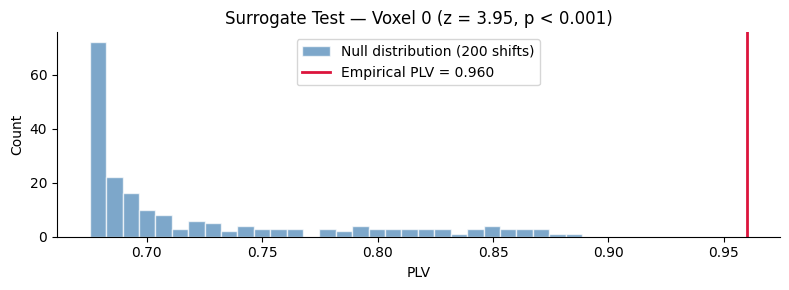

In [15]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(
    surr_dist.squeeze(),
    bins=30,
    alpha=0.7,
    color="steelblue",
    edgecolor="white",
    label="Null distribution (200 shifts)",
)
ax.axvline(emp_v0, color="crimson", linewidth=2, label=f"Empirical PLV = {emp_v0:.3f}")
ax.set_xlabel("PLV")
ax.set_ylabel("Count")
ax.set_title(f"Surrogate Test — Voxel 0 (z = {z_v0:.2f}, p < 0.001)")
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()
plt.show()

## 10. Visualizing the Coupling Map

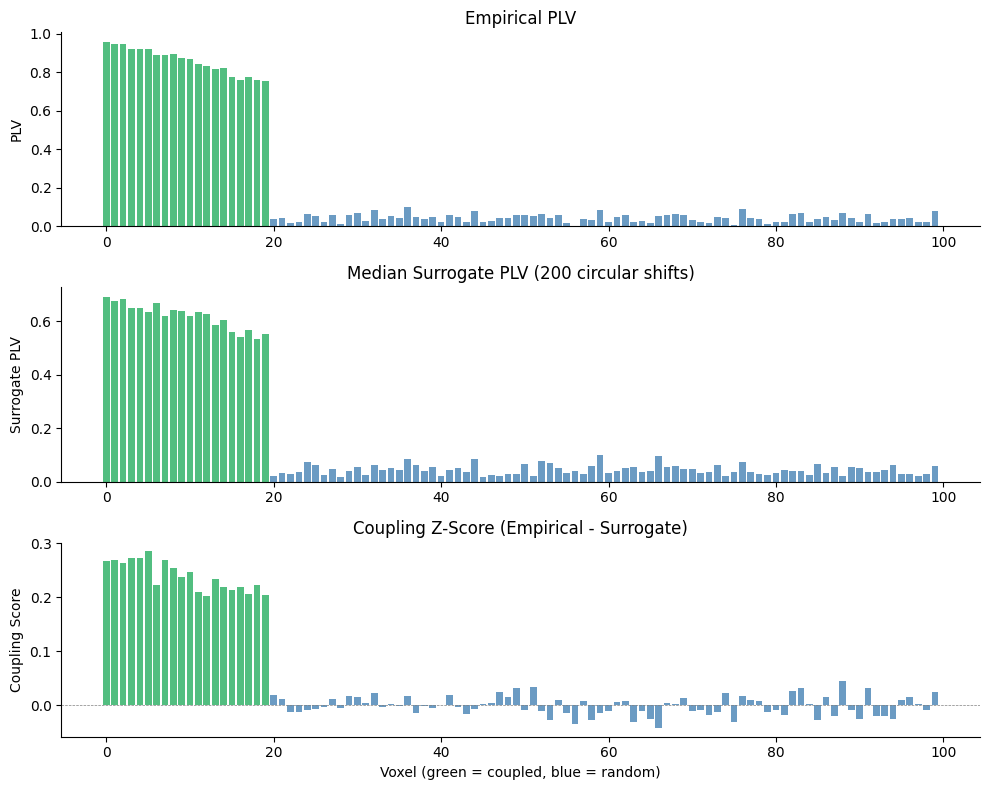

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Panel 1: Empirical PLV
ax = axes[0]
colors = ["#27AE60" if i < 20 else "steelblue" for i in range(100)]
ax.bar(range(100), plv_map, color=colors, alpha=0.8)
ax.set_ylabel("PLV")
ax.set_title("Empirical PLV")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Panel 2: Surrogate PLV
ax = axes[1]
ax.bar(range(100), surr_map, color=colors, alpha=0.8)
ax.set_ylabel("Surrogate PLV")
ax.set_title("Median Surrogate PLV (200 circular shifts)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Panel 3: Z-score
ax = axes[2]
ax.bar(range(100), z_map, color=colors, alpha=0.8)
ax.axhline(0, color="grey", linewidth=0.5, linestyle="--")
ax.set_xlabel("Voxel (green = coupled, blue = random)")
ax.set_ylabel("Coupling Score")
ax.set_title("Coupling Z-Score (Empirical - Surrogate)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.tight_layout()
plt.show()

## 11. Reconstructing a 3D Volume (Real Data)

When working with real NIfTI data, `compute_plv_map` can reconstruct
the PLV values back into a 3D volume using the brain mask:

```python
# After computing PLV on masked voxels
plv_vol = compute_plv_map(
    egg_phase, bold_phases,
    vol_shape=mask.shape,      # e.g., (65, 77, 65)
    mask_indices=mask,          # boolean 3D mask
)
# plv_vol.shape == (65, 77, 65) — zero outside mask

# Save as NIfTI
plv_img = nib.Nifti1Image(plv_vol, bold_img.affine)
nib.save(plv_img, "plv_map.nii.gz")
```

The resulting NIfTI can be loaded in any neuroimaging viewer
(FSLeyes, Nilearn, MRIcroGL) for visualization and further
group-level analysis.

## 12. Downloading Real fMRI Data

GastroPy provides `fetch_fmri_bold` to download a preprocessed
BOLD dataset (fMRIPrep, MNI space) from a GitHub Release:

```python
# Download preprocessed BOLD, mask, and confounds (cached after first download)
data = gp.fetch_fmri_bold(session="0001")

# Returns paths to local files
data["bold"]       # preprocessed BOLD NIfTI (~1.4 GB)
data["mask"]       # brain mask NIfTI
data["confounds"]  # fMRIPrep confounds TSV
data["tr"]         # 1.856 s
```

This requires the `pooch` package (included in `pip install gastropy[neuro]`)
and an internet connection for the first download.

## 13. Summary

This tutorial demonstrated the complete gastric-brain coupling pipeline:

| Step | Function | What It Does |
|------|----------|--------------|
| Channel selection | `select_best_channel` | Find strongest EGG channel |
| Narrowband filter | `apply_bandpass` | Isolate individual peak frequency |
| Phase extraction | `instantaneous_phase` | Hilbert transform → phase |
| Volume mapping | `phase_per_volume` | EGG phase → per-volume phase |
| Transient trimming | `apply_volume_cuts` | Remove filter edge artifacts |
| Confound regression | `regress_confounds` | Remove motion/noise from BOLD |
| BOLD phases | `bold_voxelwise_phases` | Filter + Hilbert on each voxel |
| PLV map | `compute_plv_map` | Voxelwise phase-locking |
| Surrogate testing | `compute_surrogate_plv_map` | Null distribution via rotation |
| Z-scoring | `coupling_zscore` | Statistical significance |

### Key Parameters

| Parameter | Default | Description |
|-----------|---------|-------------|
| `hwhm_hz` | 0.015 Hz | Narrowband filter half-width |
| `begin_cut` / `end_cut` | 21 volumes | Transient trimming |
| `n_surrogates` | all valid shifts | Number of circular shifts |
| `stat` | "median" | Summary statistic for surrogates |
| `confound_cols` | 6 motion + 6 aCompCor | Columns to regress |

### Next Steps

- Download real BOLD data with `gp.fetch_fmri_bold()` and run
  the full pipeline on actual brain data
- Use group-level statistics to identify brain regions consistently
  coupled to the gastric rhythm across participants
- Explore how coupling relates to interoceptive processing,
  mental health, and bodily self-consciousness

For more examples, see the [Example Gallery](../examples/index.rst).
For the full API, see the [API Reference](../api/index.rst).